# **Assignment 1** (Intro to Machine Learning)

## Note:

* The dataset to be used is `attrition.csv`. This dataset reveals whether a particular employee left the company or not.  
* In this dataset, the column named `Attrition` is the target variable and the remaining columns are features. Please note that `Attrition = 1` means the employee left the company, whereas `Attrition = 0` means the opposite of this statement. 
*  This dataset has been loaded in this assignment as shown below. In case, you are not able to load this data, please note that this data is stored separately as well in the assignment folder. 

In [0]:
import pandas as pd

In [6]:
data_url = "https://raw.githubusercontent.com/shala2020/shala2020.github.io/master/Lecture_Materials/Assignments/MachineLearning/L1/attrition.csv"
training_csv = pd.read_csv(data_url)
training_csv.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,ID
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5,0
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7,1
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0,2
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0,3
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2,4


## Instructions:

* You are required to use a classifier, which can predict the `Attrition` for the employees. 
* Before implementing any model, you will have to apply suitable encoding to the features and implement exploratory data analysis to know your data better. 
* You can either define your own custom-made classifer or select classifier(s) available in the `scikit-learn`.
* You are supposed to implement a minimum of three classifiers (e.g.  `RandomForestClassifier`, `XGBClassifier`, `DecisionTreeClassifier`, `KNeighborsClassifier`, etc.) and evaluate which one is giving the best peformance. 
* For each of the classifier,  report the accuracy, precision, recall, roc curve, etc. 

## Resources:

* You might want to refer to the [lecture notebook](https://github.com/shala2020/shala2020.github.io/tree/master/Lecture_Materials/Google_Colab_Notebooks/MachineLearning/L1) for revising the concepts.
* You can also refer to the pre-work material for the first lecture on ML.  

In [0]:
# imports and setting up of options
import numpy as np # array manipulation
import pandas as pd # csv import, data manipulation
import matplotlib.pyplot as plt # graph rendering
import seaborn as sns # statistical data visualization
import csv

# model feature engineering imports
import sklearn.model_selection as model_selection# split training data for training and validation
from sklearn.impute import SimpleImputer # used for handling missing data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # used for encoding categorical data
from sklearn.preprocessing import StandardScaler,RobustScaler # used for numeric feature scaling 
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score,roc_curve # check accuracy on validation data
from sklearn.compose import make_column_transformer # use different encoder of different columns

# import models to fit
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier # random forest classifier
from sklearn.svm import SVC

# display imports
from IPython.display import display # to display pandas DataFrames
import warnings
warnings.filterwarnings('ignore')

# setting library options
# Seaborn options
sns.set_style("whitegrid")
# Some matplotlib options
%matplotlib inline
# General pandas options
pd.set_option("display.width", 1000)
pd.set_option('display.max_columns', None) #show all columns of the dataset

In [0]:
# define functions

def gen_correlation_map(X):
    """
    Finding the correlation plot for numerical features to detect
    features that are necessary and discard the rest.
    mask : removes the upper triangle as it is redundant
    """
    corr = X._get_numeric_data().corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Setting up the figure
    f, ax = plt.subplots(figsize=(7,5))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, center=0.0,
                          vmax = 1, square=True, linewidths=.5, ax=ax)
    plt.show()

    
def object_headers(X):
    """
    Divide the feature dataset into categorical and numerical parts.
    Returns the categorical feature headers.
    """
    out = []
    for cols in X.columns.tolist():
        if X[cols].dtype == "object":
            out.append(cols)
    return out


def display_uniques(X):
    """
    Display the unique values of features. 
    If the #unique values > 10 : display the first 10 uniques.
    """
    for features in X:
        if len(X[features].unique())<= 10:
            print(features,":"," Count = ",len(X[features].unique()),"\n",X[features].unique())
        else:
            print(features,":"," Count = ",len(X[features].unique()),"\n",X[features].unique()[:10])

            
def fit_and_pred_classifier(classifier, X_train, X_test, y_train, y_test):
    """
    Fit the model with X_train and Y_train and predict the 
    accuracy using X_test and Y_test. Print accuracy and return 
    predicted values.
    """
    # Fit the classifier to the training data
    classifier.fit(X_train, y_train)

    # Get the prediction array
    y_pred = classifier.predict(X_test)
    
    # Get the accuracy %
    print("Accuracy with selected features: " + str(accuracy_score(y_test, y_pred) * 100) + "%") 
    print("Precision : \n",classification_report(y_test, y_pred))
    print("Confusion Matrix : \n",confusion_matrix(y_test,y_pred))
    print("ROC :")
    fper, tper, thresholds = roc_curve(y_test, y_pred) 
    plt.plot(fper, tper)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()
    print("ROC score : ",roc_auc_score(y_test,y_pred))
    return y_pred


def object_feature_engineering(X):
    """
    Input : Entire dataframe
    Output : Dataframe where all categorical data are label encoded.
    """
    X_ret = X.copy(deep=True)
    """    X_ret["Gender"] = le.fit_transform(X_ret["Gender"].astype(str))
    X_ret["OverTime"] = le.fit_transform(X_ret["OverTime"].astype(str))"""
    X_ret["BusinessTravel"]=X_ret["BusinessTravel"].map({"Non-Travel": 0,"Travel_Rarely": 1,"Travel_Frequently": 2})
    categorical = object_headers(X_ret)
    for cat in categorical:
        X_ret[cat] = le.fit_transform(X_ret[cat].astype(str))
    return X_ret


def numerical_features(X):
    """
    Returns the Numerical Feature columns of the DataFrame
    """
    categorical = object_headers(X)
    numerical = X.columns.difference(categorical)
    X_categorical = X[categorical].astype("category")
    X_numerical = X[numerical]
    return X_numerical


In [7]:
# remove duplicates if any
before_dedup = training_csv.shape[0]
training_csv.drop_duplicates(inplace=True)
print("Number of duplicates: ", before_dedup - training_csv.shape[0])

# Extracting training features and outputs
X = training_csv.drop(["Attrition"],axis=1) #independent variables
Y = training_csv["Attrition"]  #dependent variabe

# check the number of entries in the data
print("Data Vectors : ",len(X.index))

# check for null entries, if present then remove NA values by : X.dropna()
print("Checking for NULL entries : \n",X.isnull().any())

# checks for the number of features
print("Number of features : ",len(X.columns))
print(X.columns)

#check datatypes of features
print("\nData types : \n",X.dtypes)

categorical = object_headers(X)
print("The Categorical features are : \n",categorical)

Number of duplicates:  0
Data Vectors :  1028
Checking for NULL entries : 
 Age                         False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesLastYear       False
WorkLi

BEFORE


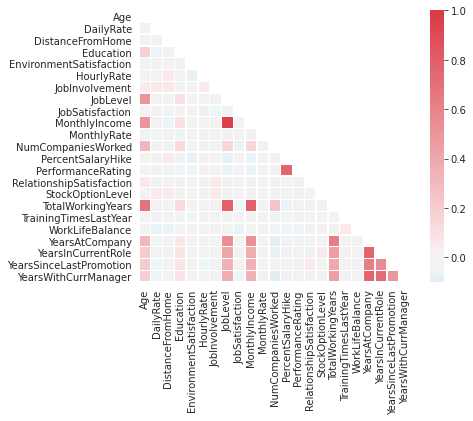

Visualize the 'Attrition' data distribution 


[Text(0.5, 1.0, 'PerformanceRating Distribution')]

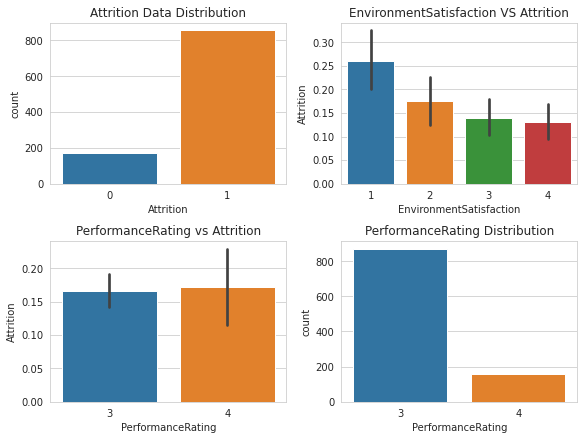

In [8]:
X_in = X.drop(["EmployeeCount","EmployeeNumber","ID"],axis=1)
X_numerical = numerical_features(X_in)
print("BEFORE")
gen_correlation_map(X_numerical)

print("Visualize the 'Attrition' data distribution ")
f, axes = plt.subplots(2, 2, figsize=(8,6), sharex=False, sharey=False,constrained_layout=True)
sns.countplot(x=Y,data=Y,ax=axes[0,0])
axes[0,0].set( title ="Attrition Data Distribution")
sns.barplot(x="EnvironmentSatisfaction",y=Y,data=X_numerical,ax=axes[0,1])
axes[0,1].set( title = "EnvironmentSatisfaction VS Attrition")
sns.barplot(x="PerformanceRating",y=Y,data=X_numerical,ax=axes[1,0])
axes[1,0].set( title = "PerformanceRating vs Attrition")
sns.countplot(x="PerformanceRating",data=X_numerical,ax=axes[1,1])
axes[1,1].set( title = "PerformanceRating Distribution")

AFTER


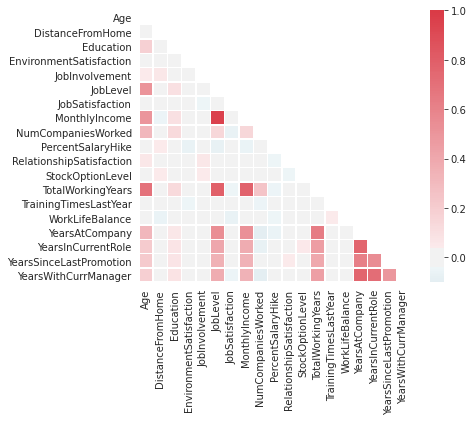

,Age,DistanceFromHome,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000
mean,36.999027,9.010700,2.873541,2.719844,2.731518,2.093385,2.757782,6632.573930,2.697471,15.172179,2.732490,0.758755,11.417315,2.769455,2.763619,7.100195,4.263619,2.210117,4.141051
std,9.444297,8.078418,1.032840,1.089614,0.703240,1.141854,1.105306,4855.747841,2.527534,3.647641,1.088774,0.836236,8.015441,1.302518,0.703005,6.316289,3.630387,3.288559,3.608460
min,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1009.000000,0.000000,11.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2886.000000,1.000000,12.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,7.000000,3.000000,3.000000,3.000000,2.000000,3.000000,4907.500000,2.000000,14.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,13.000000,4.000000,4.000000,3.000000,3.000000,4.000000,8729.500000,4.000000,18.000000,4.000000,1.000000,16.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,29.000000,5.000000,4.000000,4.000000,5.000000,4.000000,19999.000000,9.000000,25.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [9]:
remove = ["HourlyRate","DailyRate", "MonthlyRate","PerformanceRating"]
X_init = X_in.drop(remove,axis=1)
X_numerical = numerical_features(X_init)
print("AFTER")
gen_correlation_map(X_numerical)

X_numerical.describe()

In [0]:
le = LabelEncoder()
ohe = OneHotEncoder(sparse=False,drop="first")
sc = StandardScaler()
rsc = RobustScaler()

In [12]:
# Label Encoding the categorical data
X_label_encoded = object_feature_engineering(X_init)
display(X_label_encoded.head(5))

# passing the data through StandardScaler to normalize the DataFrame
sc.fit(X_label_encoded)
X_standardized = sc.transform(X_label_encoded)

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,2,1,2,1,2,0,3,2,7,4,2,5993,8,1,11,1,0,8,0,1,6,4,0,5
1,49,2,1,8,1,1,3,1,2,2,6,2,1,5130,1,0,23,4,1,10,3,3,10,7,1,7
2,37,1,1,2,2,4,4,1,2,1,2,3,2,2090,6,1,15,2,0,7,3,3,0,0,0,0
3,33,2,1,3,4,1,4,0,3,1,6,3,1,2909,1,1,11,3,0,8,3,3,8,7,3,0
4,27,1,1,2,1,3,1,1,3,1,2,2,1,3468,9,0,12,4,1,6,3,3,2,2,2,2


In [0]:
# intialize models to be used to fit and predict the TEST data
rf = RandomForestClassifier(n_estimators=400,criterion="entropy",random_state=0)
svc = SVC(kernel = 'rbf', random_state = 4,gamma=0.05,C=100)
clf = LogisticRegression(random_state=0)
gnb = GaussianNB()
neigh = KNeighborsClassifier(n_neighbors=15)
mlp = MLPClassifier(hidden_layer_sizes=(3,3),max_iter=500,random_state=0,learning_rate_init=0.01,activation="logistic",alpha = 0.1)

RF
Accuracy with selected features: 87.86407766990291%
Precision : 
               precision    recall  f1-score   support

           0       0.89      0.98      0.93       180
           1       0.56      0.19      0.29        26

    accuracy                           0.88       206
   macro avg       0.72      0.59      0.61       206
weighted avg       0.85      0.88      0.85       206

Confusion Matrix : 
 [[176   4]
 [ 21   5]]
ROC :


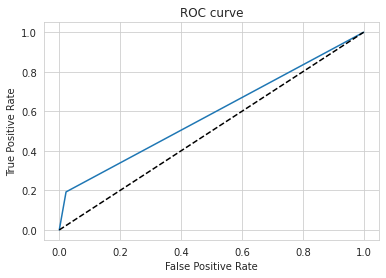

ROC score :  0.585042735042735



SVC
Accuracy with selected features: 87.37864077669903%
Precision : 
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       180
           1       0.50      0.35      0.41        26

    accuracy                           0.87       206
   macro avg       0.70      0.65      0.67       206
weighted avg       0.86      0.87      0.86       206

Confusion Matrix : 
 [[171   9]
 [ 17   9]]
ROC :


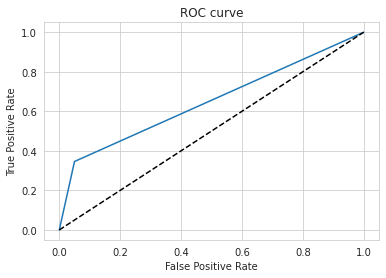

ROC score :  0.6480769230769231



CLF
Accuracy with selected features: 91.2621359223301%
Precision : 
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       180
           1       0.70      0.54      0.61        26

    accuracy                           0.91       206
   macro avg       0.82      0.75      0.78       206
weighted avg       0.91      0.91      0.91       206

Confusion Matrix : 
 [[174   6]
 [ 12  14]]
ROC :


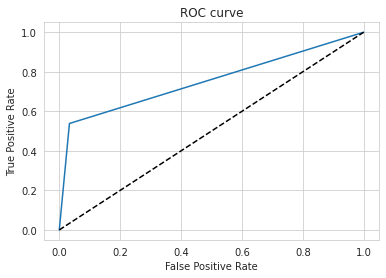

ROC score :  0.7525641025641024



GNB
Accuracy with selected features: 82.03883495145631%
Precision : 
               precision    recall  f1-score   support

           0       0.96      0.83      0.89       180
           1       0.39      0.77      0.52        26

    accuracy                           0.82       206
   macro avg       0.68      0.80      0.70       206
weighted avg       0.89      0.82      0.84       206

Confusion Matrix : 
 [[149  31]
 [  6  20]]
ROC :


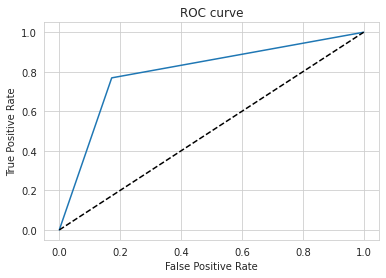

ROC score :  0.7985042735042734



NEIGH
Accuracy with selected features: 88.83495145631069%
Precision : 
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       180
           1       1.00      0.12      0.21        26

    accuracy                           0.89       206
   macro avg       0.94      0.56      0.57       206
weighted avg       0.90      0.89      0.85       206

Confusion Matrix : 
 [[180   0]
 [ 23   3]]
ROC :


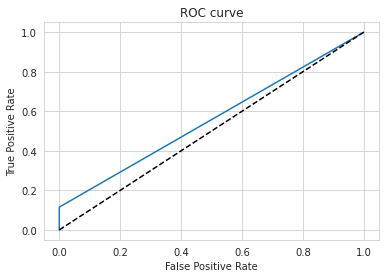

ROC score :  0.5576923076923077



MLP
Accuracy with selected features: 91.2621359223301%
Precision : 
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       180
           1       0.67      0.62      0.64        26

    accuracy                           0.91       206
   macro avg       0.81      0.79      0.80       206
weighted avg       0.91      0.91      0.91       206

Confusion Matrix : 
 [[172   8]
 [ 10  16]]
ROC :


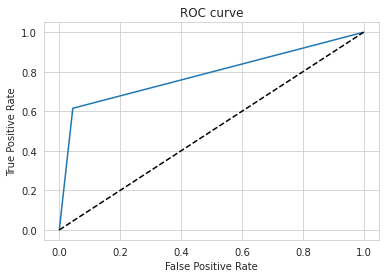

ROC score :  0.7854700854700855





In [24]:
def output(X_training,Y,classifier):
    dict_fit = {"rf":rf,"svc":svc,"clf":clf,"gnb":gnb,"neigh":neigh,"mlp":mlp}
    print(classifier.upper())
    X_train, X_validate, y_train, y_validate = model_selection.train_test_split(X_training, Y, train_size=0.8,test_size=0.2, random_state=1)
    val_pred = fit_and_pred_classifier(dict_fit[classifier],X_train, X_validate, y_train, y_validate)
    print("\n\n")

classifiers = ["rf","svc","clf","gnb","neigh","mlp"]
for i in classifiers:
    output(X_standardized,Y,i)